In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf


In [2]:
# Direktori dataset
dataset_dir = "dataset"
img_height, img_width = 224, 224
batch_size = 32

datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

datagen_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True
)

val_generator = datagen_train.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset='validation',
    shuffle=False
)

test_generator = datagen_test.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)


Found 1849 images belonging to 3 classes.
Found 461 images belonging to 3 classes.
Found 2310 images belonging to 3 classes.


In [3]:
def build_mobilenet_model(dropout_rate=0.5, optimizer='adam', fine_tune_at=None):
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    if fine_tune_at is not None:
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
    else:
        base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [4]:
def train_and_evaluate(model, model_name):
    print(f"\n🔁 Training {model_name}")
    checkpoint = ModelCheckpoint(f'{model_name}.h5', save_best_only=True, monitor='val_accuracy', mode='max')
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=20,
        callbacks=[checkpoint, early_stop]
    )

    model.summary()

    # Plot Accuracy and Loss
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.legend()
    plt.show()

    # Evaluation
    print(f"\n🧪 Evaluasi {model_name}")
    test_generator.reset()
    predictions = model.predict(test_generator)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix (Tabel):")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve & AUC
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model_name} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()



🔁 Training mobilenet_v1


c:\Users\WINDOWS 11\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5836 - loss: 1.0460

58/58 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.5853 - loss: 1.0423 - val_accuracy: 0.7007 - val_loss: 0.6994
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7842 - loss: 0.5377

58/58 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.7844 - loss: 0.5372 - val_accuracy: 0.7354 - val_loss: 0.6580
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8332 - loss: 0.4352

58/58 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.8333 - loss: 0.4349 - val_accuracy: 0.7592 - val_loss: 0.5567
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8445 - loss: 0.3818

58/58 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.8446 - loss: 0.3815 - val_accuracy: 0.7657 - val_loss: 0.5857
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.8735 - loss: 0.3314 - val_accuracy: 0.7440 - val_loss: 0.6057
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.8748 - loss: 0.3127 - val_accuracy: 0.7657 - val_loss: 0.5276
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.8636 - loss: 0.3415 - val_accuracy: 0.7375 - val_loss: 0.6203
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.8762 - loss: 0.3211 - val_accuracy: 0.7614 - val_loss: 0.4929
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8692 - loss: 0.2847

58/58 ━━━━━━━━━━━━━━━━━━━━ 217s 4s/step - accuracy: 0.8694 - loss: 0.2845 - val_accuracy: 0.7961 - val_loss: 0.4261
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.8877 - loss: 0.2702 - val_accuracy: 0.7939 - val_loss: 0.4900
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.8974 - loss: 0.2646 - val_accuracy: 0.7722 - val_loss: 0.5463
Epoch 12/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.8996 - loss: 0.2564 - val_accuracy: 0.7896 - val_loss: 0.4601
Epoch 13/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.8963 - loss: 0.2391 - val_accuracy: 0.7852 - val_loss: 0.4655
Epoch 14/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8883 - loss: 0.2858

58/58 ━━━━━━━━━━━━━━━━━━━━ 208s 3s/step - accuracy: 0.8884 - loss: 0.2855 - val_accuracy: 0.8091 - val_loss: 0.4446


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,238,091 (12.35 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

 Optimizer params: 6,152 (24.04 KB)

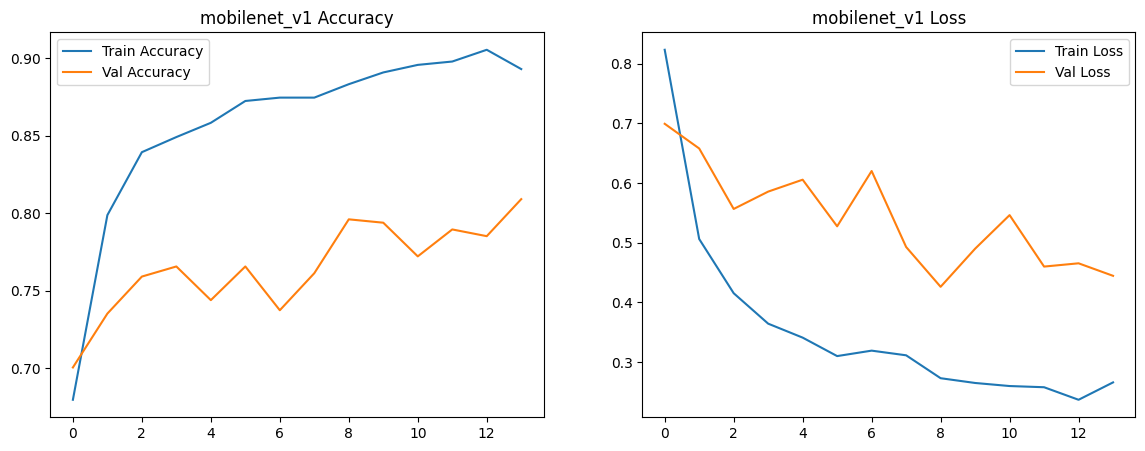


🧪 Evaluasi mobilenet_v1
73/73 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step

Classification Report:
              precision    recall  f1-score   support

       sehat       0.97      0.89      0.93       551
 tumor_ganas       0.95      0.97      0.96      1403
 tumor_jinak       0.75      0.78      0.77       356

    accuracy                           0.92      2310
   macro avg       0.89      0.88      0.88      2310
weighted avg       0.92      0.92      0.92      2310


Confusion Matrix (Tabel):
[[ 492   12   47]
 [   0 1357   46]
 [  17   60  279]]


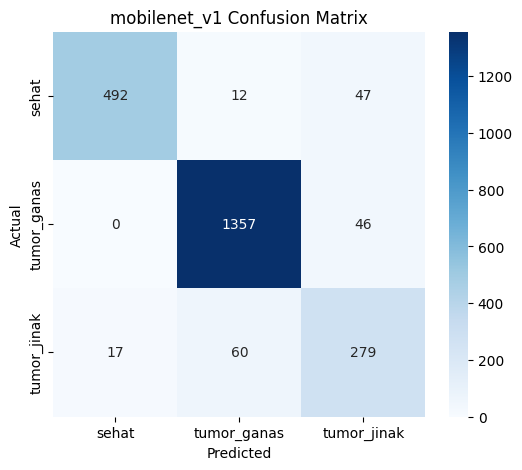

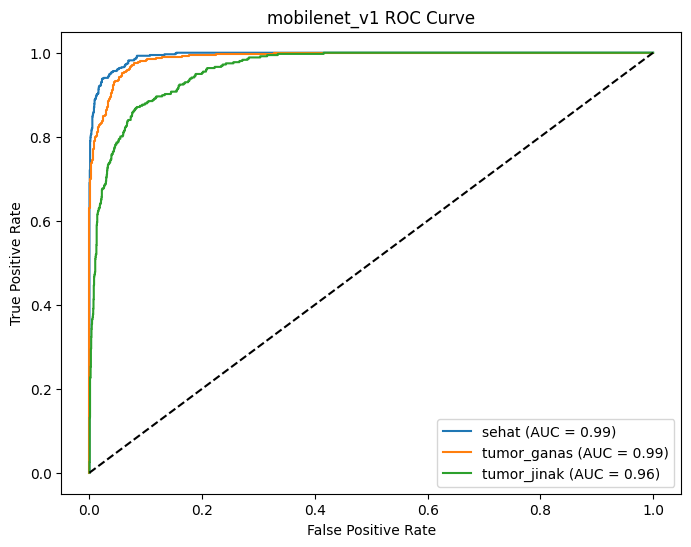

In [5]:
model_v1 = build_mobilenet_model(dropout_rate=0.5, optimizer=Adam(learning_rate=0.001), fine_tune_at=None)
train_and_evaluate(model_v1, "mobilenet_v1")



🔁 Training mobilenet_v2
Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6683 - loss: 0.8391

58/58 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.6702 - loss: 0.8342 - val_accuracy: 0.7527 - val_loss: 0.6529
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9129 - loss: 0.2277

58/58 ━━━━━━━━━━━━━━━━━━━━ 232s 4s/step - accuracy: 0.9128 - loss: 0.2278 - val_accuracy: 0.8221 - val_loss: 0.4624
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9394 - loss: 0.1646

58/58 ━━━━━━━━━━━━━━━━━━━━ 250s 4s/step - accuracy: 0.9394 - loss: 0.1645 - val_accuracy: 0.8308 - val_loss: 0.4072
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9536 - loss: 0.1339

58/58 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.9535 - loss: 0.1340 - val_accuracy: 0.8764 - val_loss: 0.3777
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.9520 - loss: 0.1297 - val_accuracy: 0.8698 - val_loss: 0.2983
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.9314 - loss: 0.1647 - val_accuracy: 0.8482 - val_loss: 0.3966
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9524 - loss: 0.1127

58/58 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.9525 - loss: 0.1127 - val_accuracy: 0.8937 - val_loss: 0.2728
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.9610 - loss: 0.0997 - val_accuracy: 0.8850 - val_loss: 0.3210
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9621 - loss: 0.1079

58/58 ━━━━━━━━━━━━━━━━━━━━ 180s 3s/step - accuracy: 0.9620 - loss: 0.1079 - val_accuracy: 0.9002 - val_loss: 0.2706
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9641 - loss: 0.0919

58/58 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.9641 - loss: 0.0920 - val_accuracy: 0.9197 - val_loss: 0.2523
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 214s 4s/step - accuracy: 0.9764 - loss: 0.0665 - val_accuracy: 0.9111 - val_loss: 0.2508
Epoch 12/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 278s 4s/step - accuracy: 0.9713 - loss: 0.0773 - val_accuracy: 0.8807 - val_loss: 0.2957
Epoch 13/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 229s 4s/step - accuracy: 0.9743 - loss: 0.0755 - val_accuracy: 0.8460 - val_loss: 0.3662
Epoch 14/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 224s 4s/step - accuracy: 0.9730 - loss: 0.0787 - val_accuracy: 0.9067 - val_loss: 0.2503
Epoch 15/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.9727 - loss: 0.0655 - val_accuracy: 0.8894 - val_loss: 0.2766
Epoch 16/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.9743 - loss: 0.0501 - val_accuracy: 0.8915 - val_loss: 0.2821
Epoch 17/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.9847 - loss: 0.0433 - val_accuracy: 0.8720 - val_l

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 5,630,664 (21.48 MB)

 Trainable params: 2,398,723 (9.15 MB)

 Non-trainable params: 833,216 (3.18 MB)

 Optimizer params: 2,398,725 (9.15 MB)

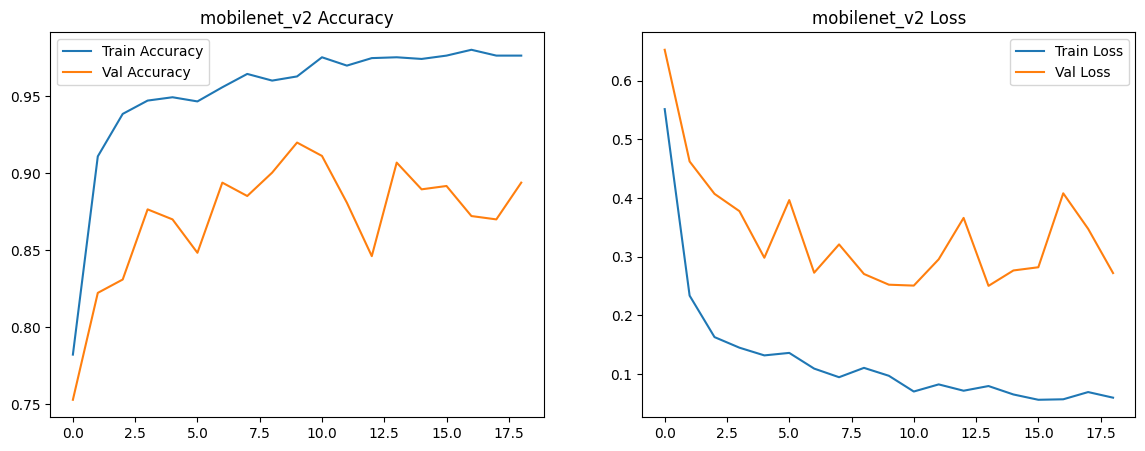


🧪 Evaluasi mobilenet_v2
73/73 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step

Classification Report:
              precision    recall  f1-score   support

       sehat       0.96      0.99      0.98       551
 tumor_ganas       0.97      0.99      0.98      1403
 tumor_jinak       0.96      0.85      0.90       356

    accuracy                           0.97      2310
   macro avg       0.96      0.94      0.95      2310
weighted avg       0.97      0.97      0.97      2310


Confusion Matrix (Tabel):
[[ 548    0    3]
 [   6 1386   11]
 [  18   36  302]]


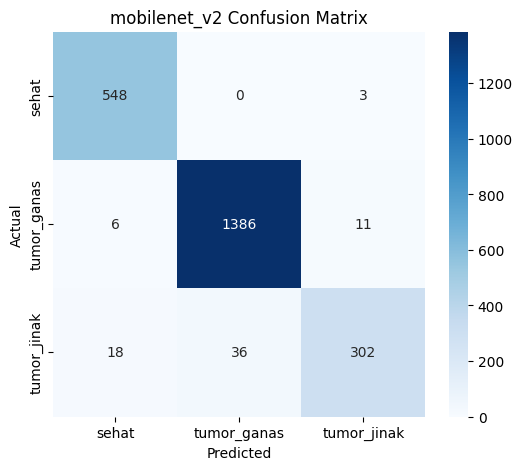

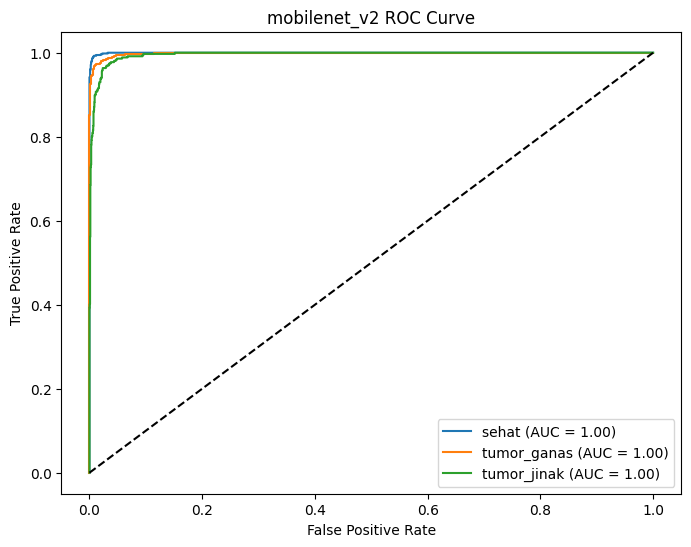

In [6]:
model_v2 = build_mobilenet_model(dropout_rate=0.3, optimizer=SGD(learning_rate=0.001, momentum=0.9), fine_tune_at=-30)
train_and_evaluate(model_v2, "mobilenet_v2")



🔁 Training mobilenet_v3
Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7949 - loss: 0.5351

58/58 ━━━━━━━━━━━━━━━━━━━━ 335s 4s/step - accuracy: 0.7964 - loss: 0.5315 - val_accuracy: 0.2516 - val_loss: 6.0821
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9370 - loss: 0.1758

58/58 ━━━━━━━━━━━━━━━━━━━━ 209s 4s/step - accuracy: 0.9371 - loss: 0.1757 - val_accuracy: 0.6269 - val_loss: 1.7479
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9374 - loss: 0.1719

58/58 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.9376 - loss: 0.1717 - val_accuracy: 0.9111 - val_loss: 0.2987
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.9701 - loss: 0.1018 - val_accuracy: 0.8937 - val_loss: 0.3459
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.9725 - loss: 0.0823 - val_accuracy: 0.8698 - val_loss: 0.4817
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9707 - loss: 0.0990 - val_accuracy: 0.8395 - val_loss: 0.7197
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9687 - loss: 0.0744 - val_accuracy: 0.8265 - val_loss: 0.9975
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9743 - loss: 0.0652

58/58 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.9742 - loss: 0.0654 - val_accuracy: 0.9241 - val_loss: 0.1945
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.9757 - loss: 0.0727 - val_accuracy: 0.8200 - val_loss: 0.7294
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9852 - loss: 0.0508 - val_accuracy: 0.8503 - val_loss: 0.6082
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9763 - loss: 0.0661 - val_accuracy: 0.9089 - val_loss: 0.4063
Epoch 12/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9827 - loss: 0.0544

58/58 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.9827 - loss: 0.0544 - val_accuracy: 0.9262 - val_loss: 0.2198
Epoch 13/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9859 - loss: 0.0496 - val_accuracy: 0.9111 - val_loss: 0.2344


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 9,383,627 (35.80 MB)

 Trainable params: 3,075,843 (11.73 MB)

 Non-trainable params: 156,096 (609.75 KB)

 Optimizer params: 6,151,688 (23.47 MB)

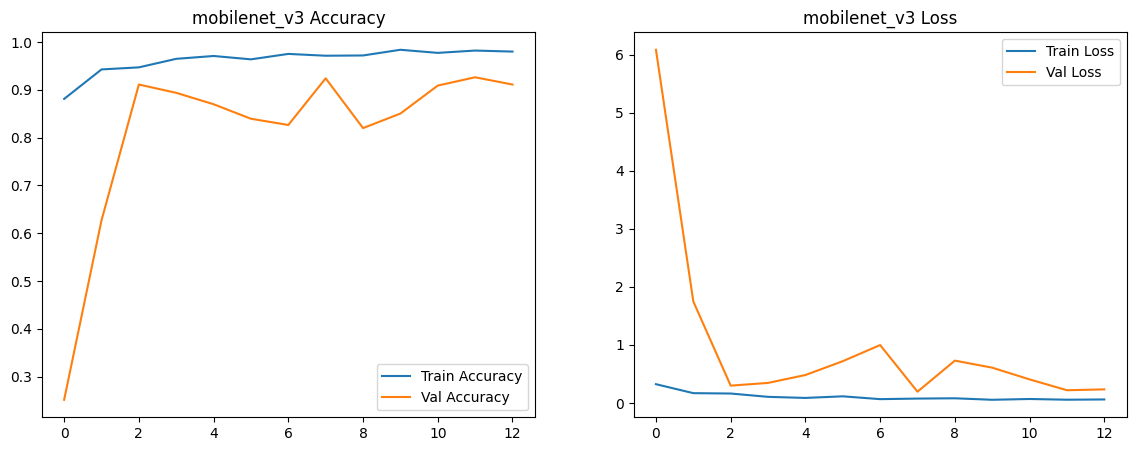


🧪 Evaluasi mobilenet_v3
73/73 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step 

Classification Report:
              precision    recall  f1-score   support

       sehat       0.99      0.99      0.99       551
 tumor_ganas       0.98      0.98      0.98      1403
 tumor_jinak       0.93      0.93      0.93       356

    accuracy                           0.98      2310
   macro avg       0.97      0.97      0.97      2310
weighted avg       0.98      0.98      0.98      2310


Confusion Matrix (Tabel):
[[ 546    3    2]
 [   0 1379   24]
 [   6   19  331]]


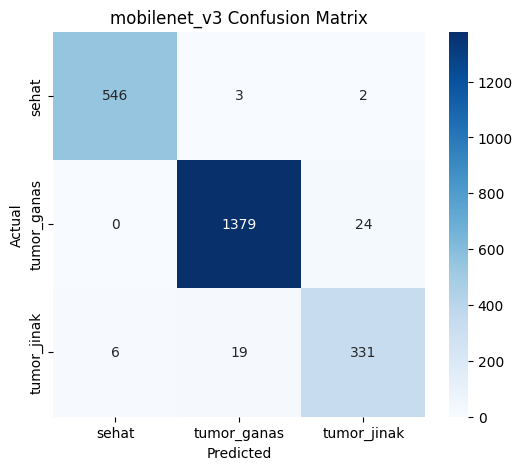

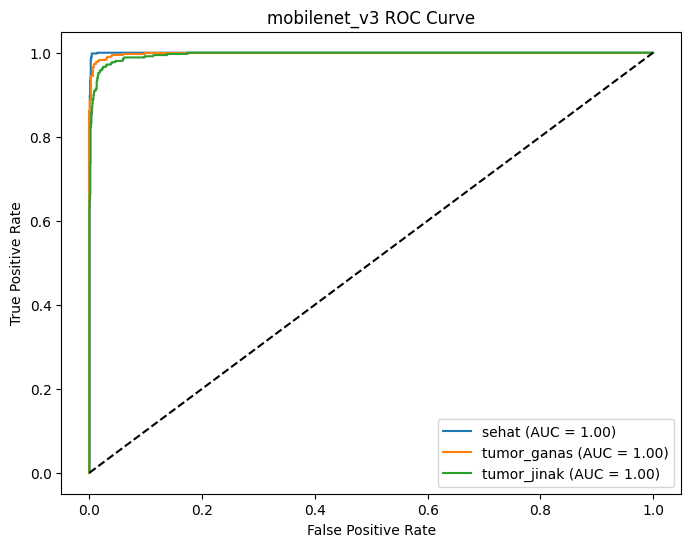

In [7]:
model_v3 = build_mobilenet_model(dropout_rate=0.4, optimizer=Adam(learning_rate=0.0005), fine_tune_at=-50)
train_and_evaluate(model_v3, "mobilenet_v3")
